In [1]:
#---------------------- RDKit package
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import PandasTools
from rdkit.Avalon import pyAvalonTools
from rdkit import Chem

#------------------- hide warning
import warnings
warnings.filterwarnings('ignore')

#----------------------------------sklearn package

from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.metrics import r2_score

# --------------------the other packages
import random 
import json
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


# Input Data

In [2]:
#loading the dataset 12110-electrolyte addtives: csv file
dataset = pd.read_csv('ALLdata12110.csv')
PandasTools.AddMoleculeColumnToFrame(dataset,'SMILES',"Structure")

#SMILES-functional groups 
fgps=['*[H]', '*C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', '*C=C', '*C', '*CC=C', '*OC(C)=O', '*OC', '*OCOC','*OC(=O)OC', '*C(=O)OC', '*C#N', 
      '*N=C=O', '*F', '*Cl', '*Br', '*c1ccccc1', '*c1cccs1', '*C(F)(F)F', '*[Si](C)(C)C','*CCC','*NC(C)=O','*C#C','*C=CC(=O)OC']

#SMILES-skeletons 
skeletons=['*COC(*)=O','*C1OC(=O)OC1*','*C1OC(=O)C(*)OC1=O','*C1OCC2(CO1)COC(*)OC2','*C(*)(OC)OC','*COC(=O)CCC(=O)OC*', '*COC(=O)CCCC(=O)OC*',
           '*COC(=O)OC*', '*C1COC(=O)C1*', '*C1CC(=O)OC1*', '*C1CC(*)C(=O)O1', '*C1OS(=O)OC1*', '*C1CCOS(=O)C1*', '*C1COS(=O)C(*)C1', 
           '*C1CCC(*)S(=O)O1','*C1COS(=O)CC1*','*C1CCS(=O)OC1*', '*C1CCS(=O)(=O)OC1*', '*C1CC(*)OS(=O)(=O)C1', '*C1CCC(*)S(=O)(=O)O1', 
           '*C1COS(=O)(=O)CC1*', '*C1COS(=O)(=O)C(*)C1', '*C1CCOS(=O)(=O)C1*', '*C(*)C', '*CC*','*C=C*','*C(*)=C','*C1C(=O)OC(=O)C1*',
           '*C#C*','*C1CC(=O)OC(=O)C1*','*C1CC(*)C(=O)OC1=O','*C1OS(=O)(=O)C(*)S(=O)(=O)O1']
            
#catagorize all molecules into 32 skeletons types
datasetsk={}

for i in range(len(skeletons)):
    datasetsk[str(skeletons[i])]=dataset[dataset.Skeletons==skeletons[i]]
print(datasetsk.keys())



dict_keys(['*COC(*)=O', '*C1OC(=O)OC1*', '*C1OC(=O)C(*)OC1=O', '*C1OCC2(CO1)COC(*)OC2', '*C(*)(OC)OC', '*COC(=O)CCC(=O)OC*', '*COC(=O)CCCC(=O)OC*', '*COC(=O)OC*', '*C1COC(=O)C1*', '*C1CC(=O)OC1*', '*C1CC(*)C(=O)O1', '*C1OS(=O)OC1*', '*C1CCOS(=O)C1*', '*C1COS(=O)C(*)C1', '*C1CCC(*)S(=O)O1', '*C1COS(=O)CC1*', '*C1CCS(=O)OC1*', '*C1CCS(=O)(=O)OC1*', '*C1CC(*)OS(=O)(=O)C1', '*C1CCC(*)S(=O)(=O)O1', '*C1COS(=O)(=O)CC1*', '*C1COS(=O)(=O)C(*)C1', '*C1CCOS(=O)(=O)C1*', '*C(*)C', '*CC*', '*C=C*', '*C(*)=C', '*C1C(=O)OC(=O)C1*', '*C#C*', '*C1CC(=O)OC(=O)C1*', '*C1CC(*)C(=O)OC1=O', '*C1OS(=O)(=O)C(*)S(=O)(=O)O1'])


#  Clustering

In [3]:
#generate image for each skeleton

def skvalue_convert_to_image(SK_tpye):
    set={}
    add=[]
    add1=[]
    for i in range(len(SK_tpye)):
  
        add.append(Chem.MolFromSmiles(skeletons[SK_tpye[i]]))
        
        add1.append(skeletons[SK_tpye[i]])
    
    set['Structure']=add
    set['StructureName']=add1
    
    df = pd.DataFrame(set)
    image=Draw.MolsToGridImage([x for x in df["Structure"]][:len(SK_tpye)+1], maxMols=100,
                     legends=[str(x) for x in df['StructureName']], subImgSize=(250,250), molsPerRow=6)
    return image


    #average LUMO values   
def sk_ave_lumo(train,trainsk):    
    lumo= [[datasetsk[skeletons[trainsk[a]]].LUMOs.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]
    avelumo= [sum(lumo[a])/len(lumo[a]) for a in range(int(len(train)))]
    return avelumo

     #average chemical hardness values 
def sk_ave_Chemical_Hardness(train,trainsk):
    chemical= [[datasetsk[skeletons[trainsk[a]]].Chemical_Hardness.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]
    avechemical= [sum(chemical[a])/len(chemical[a]) for a in range(int(len(train)))]
    
    return avechemical 
    
    # 以k-means clustering
def AVE_Kmeans(ave_value,sample,sk_tpye,knum):
    RawData={} 
    RawData['data']=ave_value
    df1 = pd.DataFrame.from_dict(RawData)

    XV = df1.iloc[:,0:1].astype('float64')
    
    #separate into knum clusters 
    model1 = KMeans(n_clusters=knum, n_init=5,random_state=1)
    model1.fit(XV) 
    
      
    plt.scatter(df1.index ,df1["data"],c=model1.labels_)

   
    sk_kms=[[] for i in range(knum)]
    kmeans=model1.predict(XV)
    for a in range(len(kmeans)):
        for b in range(knum):
            if kmeans[a]==b:
                sk_kms[b].append(sk_tpye[a])
        
    return sk_kms
    


# Ring-Type and Chain-Type clustering

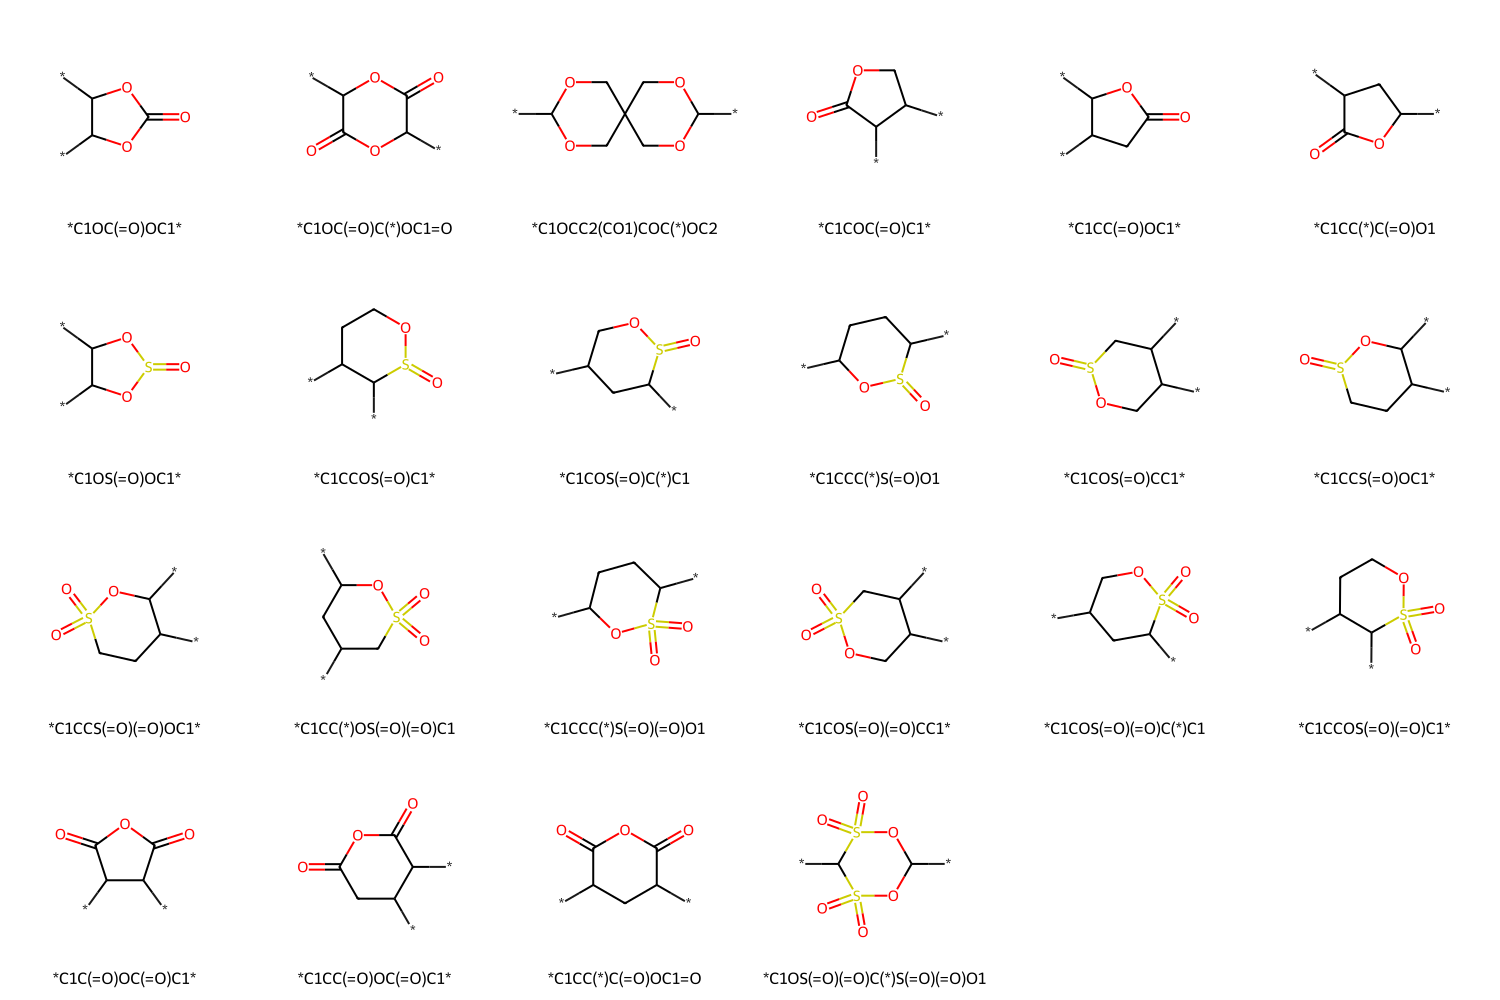

In [4]:
#Ring-Type
cyc=[ 1, 2,3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,27,29, 30,31]
skvalue_convert_to_image(cyc)

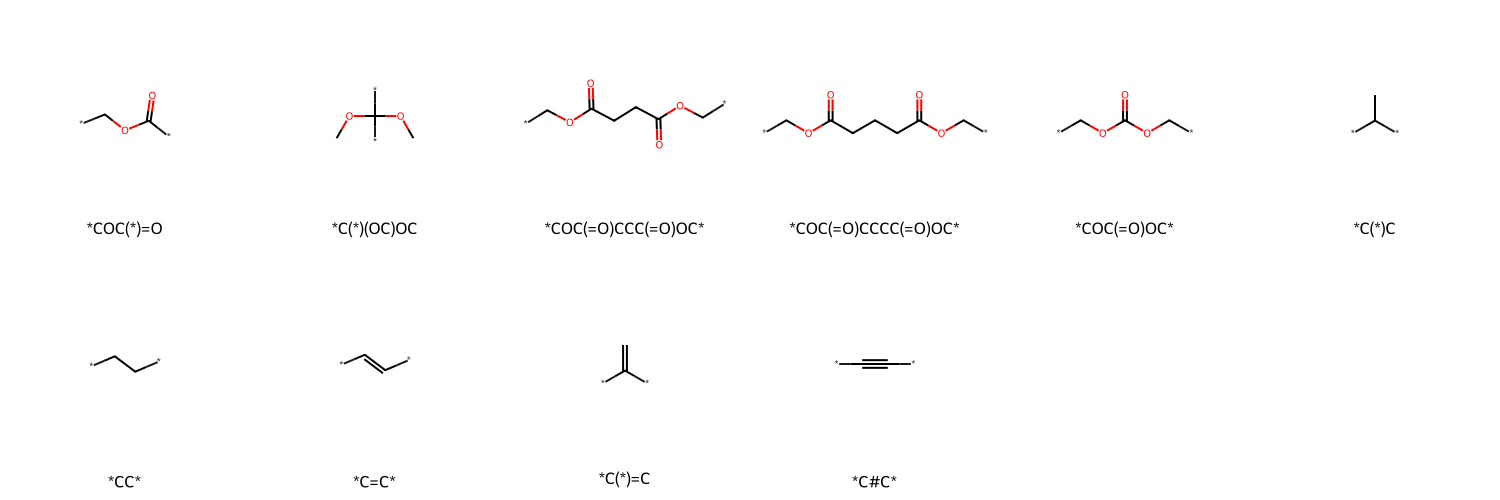

In [7]:
#Chain-tpye
chain=[0,  4, 5, 6, 7, 23, 24,25, 26, 28]
skvalue_convert_to_image(chain)

# K-means clustering

cluster 1:['*C1OC(=O)OC1*', '*C1OCC2(CO1)COC(*)OC2', '*C1COC(=O)C1*', '*C1CC(=O)OC1*', '*C1CC(*)C(=O)O1', '*C1OS(=O)OC1*', '*C1CCOS(=O)C1*', '*C1COS(=O)C(*)C1', '*C1CCC(*)S(=O)O1', '*C1COS(=O)CC1*', '*C1CCS(=O)OC1*', '*C1CCS(=O)(=O)OC1*', '*C1CC(*)OS(=O)(=O)C1', '*C1CCC(*)S(=O)(=O)O1', '*C1COS(=O)(=O)CC1*', '*C1COS(=O)(=O)C(*)C1', '*C1CCOS(=O)(=O)C1*']
cluster 2:['*C1OC(=O)C(*)OC1=O', '*C1C(=O)OC(=O)C1*', '*C1CC(=O)OC(=O)C1*', '*C1CC(*)C(=O)OC1=O', '*C1OS(=O)(=O)C(*)S(=O)(=O)O1']
cluster 1(skeleton #):[1, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
cluster 2(skeleton #):[2, 27, 29, 30, 31]


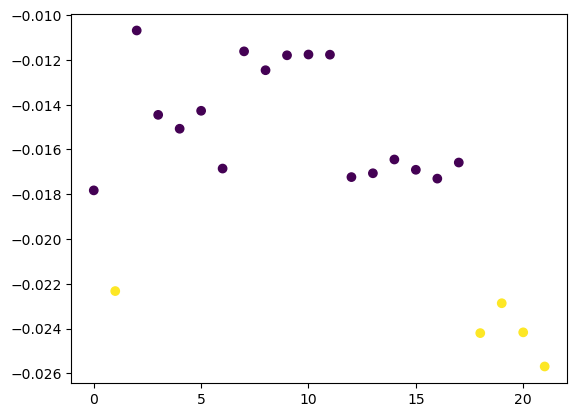

In [5]:
# clustering clustering the ring-type by k-means 

# sampling 80% data to calculate average LUMO value for each ring-type dataset
rate=0.8 
cyc_samples=[random.sample(range(len(datasetsk[skeletons[cyc[a]]]['No'].values)), int((len(datasetsk[skeletons[cyc[a]]]['No'].values))*(rate)))for a in range(len(cyc))]

  
AVE_value_cyc=sk_ave_lumo(cyc_samples,cyc) #  average LUMO
#AVE_value_cyc=sk_ave_Chemical_Hardness(cyc_samples,cyc) #  average chemical hardness

knumber=2 #separate into 2 groups
cycsk=AVE_Kmeans(AVE_value_cyc,cyc_samples,cyc,knumber) 
cluster_ring=[[skeletons[cycsk[i][a]] for a in range(len(cycsk[i]))]for i in range(len(cycsk))]
    
print("cluster 1:"+str(cluster_ring[0]))
print("cluster 2:"+str(cluster_ring[1]))
print("cluster 1(skeleton #):"+str(cycsk[0]))
print("cluster 2(skeleton #):"+str(cycsk[1]))


In [6]:
# clustering clustering the ring-type by k-means 

# sampling 80% data to calculate average chemical hardness value for each ring-type dataset
rate=0.8 
chain_samples=[random.sample(range(len(datasetsk[skeletons[chain[a]]]['No'].values)), int((len(datasetsk[skeletons[chain[a]]]['No'].values))*(rate)))for a in range(len(chain))]

AVE_value_chain=sk_ave_lumo(chain_samples,chain) #  average LUMO
#AVE_value_chain=sk_ave_Chemical_Hardness(chain_samples,chain) #  average chemical hardness

knumber=2 #separate into 2 groups
chainsk=AVE_Kmeans(AVE_value_chain,chain_samples,chain,knumber)
cluster_chain=[[skeletons[chainsk[i][a]] for a in range(len(chainsk[i]))]for i in range(len(chainsk))]
                                                                                            
print("cluster 1:"+str(cluster_chain[0]))
print("cluster 2:"+str(cluster_chain[1]))
print("cluster 1(skeleton #):"+str(chainsk[0]))
print("cluster 2(skeleton #):"+str(chainsk[1]))                                                                                     


NameError: name 'chain' is not defined

# Notes

In [8]:
#clustering with LUMOs 
#ring
#cluster 1:['*C1OC(=O)OC1*', '*C1OCC2(CO1)COC(*)OC2', '*C1COC(=O)C1*', '*C1CC(=O)OC1*', '*C1CC(*)C(=O)O1', '*C1OS(=O)OC1*', '*C1CCOS(=O)C1*', '*C1COS(=O)C(*)C1', '*C1CCC(*)S(=O)O1', '*C1COS(=O)CC1*', '*C1CCS(=O)OC1*', '*C1CCS(=O)(=O)OC1*', '*C1CC(*)OS(=O)(=O)C1', '*C1CCC(*)S(=O)(=O)O1', '*C1COS(=O)(=O)CC1*', '*C1COS(=O)(=O)C(*)C1', '*C1CCOS(=O)(=O)C1*']
#cluster 2:['*C1OC(=O)C(*)OC1=O', '*C1C(=O)OC(=O)C1*', '*C1CC(=O)OC(=O)C1*', '*C1CC(*)C(=O)OC1=O', '*C1OS(=O)(=O)C(*)S(=O)(=O)O1']
#chain
#cluster 1:['*C(*)(OC)OC', '*COC(=O)CCC(=O)OC*', '*COC(=O)CCCC(=O)OC*', '*COC(=O)OC*', '*C(*)C', '*CC*']
#cluster 2:['*COC(*)=O', '*C=C*', '*C(*)=C', '*C#C*']

#clustering with chemical hardness 
#ring
#cluster 1:['*C1OC(=O)OC1*', '*C1OCC2(CO1)COC(*)OC2', '*C1COC(=O)C1*', '*C1CC(=O)OC1*', '*C1CC(*)C(=O)O1', '*C1OS(=O)OC1*', '*C1CCOS(=O)C1*', '*C1COS(=O)C(*)C1', '*C1CCC(*)S(=O)O1', '*C1COS(=O)CC1*', '*C1CCS(=O)OC1*', '*C1CCS(=O)(=O)OC1*', '*C1CC(*)OS(=O)(=O)C1', '*C1CCC(*)S(=O)(=O)O1', '*C1COS(=O)(=O)CC1*', '*C1COS(=O)(=O)C(*)C1', '*C1CCOS(=O)(=O)C1*']
#cluster 2:['*C1OC(=O)C(*)OC1=O', '*C1C(=O)OC(=O)C1*', '*C1CC(=O)OC(=O)C1*', '*C1CC(*)C(=O)OC1=O', '*C1OS(=O)(=O)C(*)S(=O)(=O)O1']
#chain
#cluster 1:['*COC(*)=O', '*C(*)(OC)OC', '*COC(=O)CCC(=O)OC*', '*COC(=O)CCCC(=O)OC*', '*COC(=O)OC*', '*C(*)C', '*CC*']
#cluster 2:['*C=C*', '*C(*)=C', '*C#C*']

#  Training

In [7]:
  #generate defined features for training data 
def code_Generator_defined(train,trainsk,avbits,calcul_type):

       #establish skeleton(sklt) and function group at site 1(fg1) and 2(fg2) for each training data
    fg1=[[datasetsk[skeletons[trainsk[a]]].FunctionalGroups1.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]
    fg2=[[datasetsk[skeletons[trainsk[a]]].FunctionalGroups2.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]
    sklt=[[datasetsk[skeletons[trainsk[a]]].Skeletons.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]

      
    #Morgan Fingerprints of skeletons and function groups at site 1 and 2 
    
    M_fg1=[[np.array( mfpgen.GetFingerprint (sk_fg_glue(sklt[a][i],fg1[a][i],"*"))) for i in range(len(train[a]))]for a in range(int(len(train)))]
    M_fg2=[[np.array( mfpgen.GetFingerprint (sk_fg_glue(sklt[a][i],"*",fg2[a][i]))) for i in range(len(train[a]))]for a in range(int(len(train)))]
    M_sk=[[np.array( mfpgen.GetFingerprint (sk_fg_glue(sklt[a][i],"*","*"))) for i in range(len(train[a]))]for a in range(int(len(train)))]

    # establish feature for each training data 
    # M_fg1[a][i]*M_sk[a][i] and M_fg2[a][i]*M_sk[a][i]: overlaping fingerprints between function group at site 1 and 2 and skelelton
    code=[[(M_fg1[a][i]-M_fg1[a][i]*M_sk[a][i])+(M_fg2[a][i]-M_fg2[a][i]*M_sk[a][i])+M_sk[a][i] for i in range(len(train[a]))]for a in range(int(len(train)))]

    #establish chemical property for each training data 
    
    lumo= [[datasetsk[skeletons[trainsk[a]]].LUMOs.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]
    CH= [[datasetsk[skeletons[trainsk[a]]].Chemical_Hardness.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]

      #establish information for each training data
      #calcul_type==0 establish LUMO information, calcul_type==1 establish LUMO chemical hardness information 
    x=[]
    y=[]
    for i in range(len(train)):
        for a in range(len(train[i])):
            x.append(code[i][a])
            if calcul_type==0:
                y.append(lumo[i][a])
            if calcul_type==1:  
                y.append(CH[i][a])
    return x,y

 #generate original fingerprint as features for training data 
def code_Generator_original(train,trainsk,avbits,calcul_type):

    fg1=[[datasetsk[skeletons[trainsk[a]]].FunctionalGroups1.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]
    fg2=[[datasetsk[skeletons[trainsk[a]]].FunctionalGroups2.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]
    sklt=[[datasetsk[skeletons[trainsk[a]]].Skeletons.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]

    
    #Morgan Fingerprint as features for each training data
    code=[[np.array(mfpgen.GetFingerprint(sk_fg_glue(sklt[a][i],fg1[a][i],fg2[a][i]))) for i in range(len(train[a]))]for a in range(int(len(train)))]


    lumo= [[datasetsk[skeletons[trainsk[a]]].LUMOs.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]
    CH= [[datasetsk[skeletons[trainsk[a]]].Chemical_Hardness.values[train[a][i]] for i in range(len(train[a]))]for a in range(int(len(train)))]

    x=[]
    y=[]
    for i in range(len(train)):
        for a in range(len(train[i])):
            x.append(code[i][a])
            if calcul_type==0:
                y.append(lumo[i][a])
            if calcul_type==1:  
                y.append(CH[i][a])
    return x,y


 #calculate the prediction results yred:prediction  yexp:calculation from DFT 
def yexp_ypred(test,yexp,Reg_model):
    ypred=[]
    
    for i in range(len(test)):
        ypred.append([np.matmul(Reg_model.coef_,test[i]) +Reg_model.intercept_])

    return yexp, ypred

  #calculate R2 and RMSE
def r2_rmse(yexp,ypred):
    rmse=0
    regr = LinearRegression().fit(ypred,yexp)

    for i in range(len(yexp)):
        
        rmse=rmse+(ypred[i]-yexp[i])**2
    
    return {'r2':regr.score(ypred, yexp),'rmse':math.sqrt(rmse/len(yexp))}



  # code to glue skeleton and functional group together
def sk_fg_glue(i_skeleton,func_group1,func_group2):
    skeleton = Chem.MolFromSmiles(i_skeleton)
    func_group1 = Chem.MolFromSmiles(func_group1)
    func_group2 = Chem.MolFromSmiles(func_group2)
    combination = Chem.CombineMols(skeleton, func_group1)
    combination = Chem.CombineMols(combination, func_group2)

    r_loc = []
    for k in range(combination.GetNumAtoms()):
        atom = combination.GetAtoms()[k].GetSymbol()
        if atom == '*':
            r_loc.append(k)
            # connect between the skeleton and functional group
    edit_mol = Chem.EditableMol(combination)
    edit_mol.AddBond(r_loc[0], r_loc[2], order=Chem.rdchem.BondType.SINGLE)
    edit_mol.AddBond(r_loc[1], r_loc[3], order=Chem.rdchem.BondType.SINGLE)
    combination = edit_mol.GetMol()
    combination_smiles = Chem.MolToSmiles(combination)
            # correct the SMLIES afther gluing
    combination_smiles = combination_smiles.replace('**', '')
    combination_smiles = combination_smiles.replace('()', '')
    if combination_smiles.count('*(*') > 0:    
       # print(combination_smiles)
        combination_smiles = smiles_fix(combination_smiles)
    
    mol = Chem.MolFromSmiles(combination_smiles)
    return  mol

def smiles_fix(smiles):
    smiles = smiles.replace('*(*', '(', 1)
    branches = []
    # find (..), (..(..)..), and (..(..)..(..)..), use & to represent a branch
    num_of_parens = len(re.findall('\(\w+\)|\(\w*\(\w+\)\w*\)|\(\w*\(\w+\)\w*\(\w+\)\w*\)', smiles))
    for i in range(num_of_parens):
        branches.append(re.search('\(\w+\)|\(\w*\(\w+\)\w*\)|\(\w*\(\w+\)\w*\(\w+\)\w*\)', smiles).group(0))
        smiles = smiles.replace(branches[i], '&', 1)
    # deal with smiles start from branch
    if smiles[0] == '&':
        smiles = re.sub('(&)([A-Za-z]\d?)', r'\2\1', smiles, 1)

    for i in range(num_of_parens):
        branches[i] = branches[i].replace('1', f'{i*2+4}')
        branches[i] = branches[i].replace('2', f'{i*2+5}')
        smiles = smiles.replace('&', branches[i], 1)
    return smiles

# R2 and RMSE for features with clustered or unclustered data

In [8]:
from rdkit.Chem import rdFingerprintGenerator

# Morgen fingerprint as ECFP4
bits=1024  #number of bits for a fingerprint
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=bits)
rate=0.8

#--- function for feautres----
#---- deined features: code_Generator_defined()
#---- oringal fingerprint as features: code_Generator_original()

#set of parameters:
# ---1. clustered and LUMO prediction----

bits=1024
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=bits)
chainsk=[[0, 25, 26, 28], [4, 5, 6, 7, 23, 24]]
cycsk=[[2, 29,27, 30,31],[1, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]]
value=0
taskname=r"LUMO"

# ---2. unclustered and LUMO prediction----

#bits=4096
#mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=bits)
#cycsk=[[i for i in range(len(skeletons))]]
#chainsk=[]
#value=0
#taskname=r"LUMO"

# ---3. clustered and Chemical Hardness prediction----

#bits=1024
#mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=bits)
#cycsk=[[12, 13, 14, 15, 16],[1, 2, 3, 8, 9, 10, 11, 17, 18, 19, 20, 21, 22, 27, 29, 30, 31]]
#chainsk=[[0, 4, 5, 6, 7, 23, 24], [25, 26, 28]]
#value=1
#taskname=r"Chemical Hardness"

# ---4. unclustered and Chemical Hardness prediction----

#bits=4096
#mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=bits)
#cycsk=[[i for i in range(len(skeletons))]]
#chainsk=[]
#value=1
#taskname=r"Chemical Hardness"

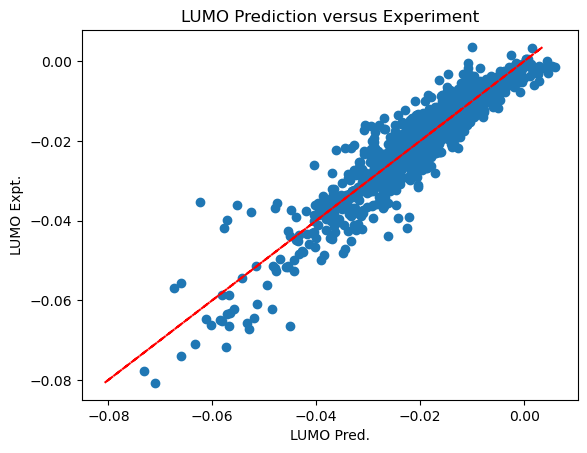

{'r2': 0.8896771312720905, 'rmse': 0.0033315620726946335}

In [11]:

pred_total=[]
exp_total=[]
regT=[[],[]]


#----training for ring-type-----#
for t in range(len(cycsk)):
    
         
    cyc_sample=[[i for i in range(len(datasetsk[skeletons[cycsk[t][a]]]['No'].values))]for a in range(len(cycsk[t]))]
        # generate taining data
    cyc_test=[random.sample(range(len(cyc_sample[a])), int((len(cyc_sample[a]))*(1-rate)))for a in range(int(len(cycsk[t])))]
        # generate test data
    cyc_train=[list(set(cyc_sample[a])-set(cyc_test[a]))for a in range(len(cycsk[t]))]

    
      #-----establish deined features for training data and test data-----
    atrain_cyc=code_Generator_defined(cyc_train,cycsk[t],bits,value)
    atest_cyc=code_Generator_defined(cyc_test,cycsk[t],bits,value)
    
     #------establish original fingerprint as features for training data and test data-----
    #atrain_cyc=code_Generator_original(cyc_train,cycsk[t],bits,value)
    #atest_cyc=code_Generator_original(cyc_test,cycsk[t],bits,value)
    
      #train the model
    reg1=linear_model.BayesianRidge()
    reg1.set_params(alpha_init=5,lambda_init=0.000001)
    
    reg=reg1.fit(atrain_cyc[0],atrain_cyc[1])
    
    #calculate the prediction for each test data from the model
    cyc_yexp_ypred=yexp_ypred(atest_cyc[0],atest_cyc[1],reg) 

    exp_total.extend(cyc_yexp_ypred[0])
    pred_total.extend(cyc_yexp_ypred[1])

    #restore the training result of the model
    regT[0].append(reg)
 
#----training for chain-type-----#
for t in range(len(chainsk)):
    rate=0.8
    
    chain_sample=[[i for i in range(len(datasetsk[skeletons[chainsk[t][a]]]['No'].values))]for a in range(len(chainsk[t]))]
    chain_test=[random.sample(range(len(chain_sample[a])), int((len(chain_sample[a]))*(1-rate)))for a in range(int(len(chainsk[t])))]
    chain_train=[list(set(chain_sample[a])-set(chain_test[a]))for a in range(len(chainsk[t]))]
    
    #-----establish deined features for training data and test data-----
    atrain_chain=code_Generator_defined(chain_train,chainsk[t],bits,value)
    atest_chain=code_Generator_defined(chain_test,chainsk[t],bits,value)
    
     #------establish original fingerprint as features for training data and test data-----
    #atrain_chain=code_Generator_original(chain_train,chainsk[t],bits,value)
    #atest_chain=code_Generator_original(chain_test,chainsk[t],bits,value)
    
    reg1=linear_model.BayesianRidge()
    reg1.set_params(alpha_init=5,lambda_init=0.000001)

    reg=reg1.fit(atrain_chain[0],atrain_chain[1])
    chain_yexp_ypred=yexp_ypred(atest_chain[0],atest_chain[1],reg)

    
    exp_total.extend(chain_yexp_ypred[0])
    pred_total.extend(chain_yexp_ypred[1])
    regT[1].append(reg)


plt.plot(pred_total,exp_total,'o') 
plt.plot(exp_total, exp_total,linestyle = 'dashed',color='red')
plt.xlabel(taskname+' Pred.')
plt.ylabel(taskname+' Expt.')
plt.title(taskname+r' Prediction versus Experiment')
plt.show()        
r2_rmse(exp_total,pred_total)